In [1]:
import discretize as ds
import SimPEG.potential_fields as pf
from SimPEG import (
    maps, utils, simulation, inverse_problem, inversion, optimization, regularization, data_misfit, directives
)
from SimPEG.utils import io_utils
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as cm
from matplotlib import rc

from scipy.interpolate import NearestNDInterpolator

import seaborn
#seaborn.reset_orig()
#seaborn.set()
rc('text', usetex=True)

# Load models

In [2]:
mesh = ds.TreeMesh.readUBC('../Assets/mesh_CaMP.ubc')

In [3]:
true_mag_model = mesh.readModelUBC('../Assets/1block_synthetic_model.ubc')
geology_model = true_mag_model.copy()
true_density_model = true_mag_model.copy()
geology_model[true_mag_model==0.05] = 1
geology_model[true_mag_model==.15] = 2
true_density_model[true_mag_model==0.05] = 0.1
true_density_model[true_mag_model==.15] = -0.2

In [4]:
gravity_l22 = mesh.read_model_UBC('../gravity_inversions/minv_Tik_dw_as1.6e-05.den')
gravity_lpq = mesh.read_model_UBC('../gravity_inversions_LpLq/minv_defaultSmooth1_dw_as1.0.den')

magnetic_l22 = mesh.read_model_UBC('../magnetic_inversions/minv_Tik_dw_as1.6e-05.sus')
magnetic_lpq = mesh.read_model_UBC('../magnetic_inversions_LpLq/minv_defaultSmooth1_dw_as1.sus')


# Geophysical data

In [5]:
data_grav = io_utils.read_grav3d_ubc('../Assets/1block_gravity_data.obs')
data_mag = io_utils.read_mag3d_ubc('../Assets/1block_magnetic_data.obs')


# plotting functions and parameters

In [6]:
norm_grav_data = cm.TwoSlopeNorm(vmax=(-data_grav.dobs).max(), vcenter=0, vmin=(-data_grav.dobs).min())
norm_mag_data = cm.TwoSlopeNorm(vmax=data_mag.dobs.max(), vcenter=0, vmin=data_mag.dobs.min())

In [7]:
titlesize = 28
labelsize = 24
ticksize = 22

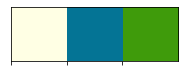

In [8]:
# create geology colorcode
colors = ["xkcd:off white", 'xkcd:sea blue', "#3f9b0b",] #,'#7CFC79', '#080A7F'
seaborn.palplot(colors)
geocmap = cm.ListedColormap(colors, name='from_list', N=None)

In [9]:
def plotting_model(
    ax,
    mesh,
    plot_model,
    clim,
    cmap,
    legend_cb,
    geology_model = geology_model,
    slicex=0.,
    slicey=0.,
    slicez= -550,
    plot_grid=False,
    is_geology=False,
    title='',
    plot_cb=True,
    is_vector=False,
    is_spherical=True,
    quiver_opts = {'scale':0.2, 'scale_units':"inches"},
    titlesize = 20,
    labelsize = 18,
    ticksize = 16,
    meshplotOpts = {},
    
):
    if is_vector:
        if is_spherical:
            plot_model = utils.mat_utils.spherical2cartesian(
                plot_model.reshape((mesh.nC, 3), order="F")
            )
        plot_model = plot_model.reshape((len(mesh), 3), order='F')
        plotOpts = {'v_type':'CCv', 'view':'vec', 'quiver_opts':quiver_opts}
    else:
        plotOpts = {}
    
    ind_xy = int(np.where(mesh.vectorCCz == mesh.vectorCCz[np.abs(mesh.vectorCCz-slicez).argmin()])[0][0])
    ind_xz = int(np.where(mesh.vectorCCy == mesh.vectorCCy[np.abs(mesh.vectorCCy-slicey).argmin()])[0][0])
    ind_yz = int(np.where(mesh.vectorCCx == mesh.vectorCCx[np.abs(mesh.vectorCCx-slicex).argmin()])[0][0])

    indslicezplot = mesh.gridCC[:,2] == mesh.vectorCCz[ind_xy]
    indsliceyplot = mesh.gridCC[:,1] == mesh.vectorCCy[ind_xz]
    indslicexplot = mesh.gridCC[:,0] == mesh.vectorCCx[ind_yz]
    
    #plot true model
    for j, (plane, indd) in enumerate(zip([[0,1],[0,2],], [indslicezplot, indsliceyplot,])):
        _, _, CS = utils.plot2Ddata(
            mesh.gridCC[indd][:,plane],geology_model[indd],nx=200,ny=200,
            clim=[0,2],
             contourOpts={'alpha':0},
             ax=ax[j],
             level=True,
             ncontour=2,
             levelOpts={
                 'colors':'k','linewidths':2,#'linestyles':'dotted', 
                 #'label':'True geology contour'
             },
            method='nearest'
        )   
        CS.collections[0].set_label('True geology model (contours)')
    #PLAN MAP
    mm = mesh.plotSlice(
        plot_model,normal='Z', ind=ind_xy, clim=clim,
        grid=plot_grid,pcolorOpts={'cmap':cmap,**meshplotOpts},
        ax=ax[0],
        **plotOpts,
    )
    ax[0].set_xlabel('')#'X (m)', fontsize=18)
    ax[0].set_ylabel('Y (m)', fontsize=labelsize)
    
    ax[0].plot(
        [-16000,16000],np.ones(2)*mesh.vectorCCy[ind_xz],
        linestyle='dashed',linewidth=3,c='xkcd:dark gray', 
        label='cross-section location'
    )
    ax[0].legend(fontsize=labelsize)
    ax[0].set_yticks(np.linspace(-15000,15000,7))
    ax[0].set_yticklabels(
        ['${}$'.format(lbl) for lbl in np.linspace(-15000,15000,7,dtype='int')], 
        va='center', ha='center'
    )
    ax[0].set_xticklabels('');
    ax[0].set_xlabel('');
    
    #EW SECTION
    #fix the colorbar for vector plot
    if is_vector:
        mm = mesh.plotSlice(
            np.linalg.norm(plot_model, axis=1),normal='Y',ind=ind_xz, clim = clim,
            grid=plot_grid,pcolorOpts={'cmap':cmap,'alpha':1},
            ax=ax[1],
        )
    mesh.plotSlice(
        plot_model,normal='Y',ind=ind_xz, clim = clim,
        grid=plot_grid,pcolorOpts={'cmap':cmap,**meshplotOpts},
        ax=ax[1],
        **plotOpts,
    )
    ax[1].set_xlabel('X (m)', fontsize=labelsize)
    ax[1].set_ylabel('Z (m)', fontsize=labelsize)
    ax[1].plot(
        [-16000,16000],np.ones(2)*mesh.vectorCCz[ind_xy],
        linestyle='dashed',linewidth=3,c='xkcd:dark gray'
    )
    ax[1].set_yticks([-6000,-3000,0])
    ax[1].set_yticklabels(
        ['$-6000$','$-3000$','$0$'], 
        va='center', ha='center'
    )
    
    #General formatting
    for axx in ax:
        axx.set_aspect('equal')
        axx.tick_params(labelsize=ticksize)
        axx.set_title('')#ax[0].get_title(),fontsize=20)
        axx.tick_params(axis='y',rotation=90)
    ax[0].set_title(title,fontsize=titlesize)
    #ADJUST SPACE IN FIGURE
    #fig.subplots_adjust(hspace=-0.45)

    #colorbar
    #cbaxes = fig.add_axes([0.95, 0.5, 0.025, 0.25])
    #fix the colorbar for vector plot
    if plot_cb:
        cb = plt.colorbar(mm[0],cax=ax[2])
        cb.ax.set_aspect(20)
        if is_geology:
            cb.set_ticks([0.33,1,1.67])
            cb.ax.set_yticklabels(
                ['Background','Carbonated', 'Serpentinized'],
                va='center',ha='center'
            )
        cb.set_label(legend_cb, fontsize=labelsize)
        cb.outline.set_edgecolor('k')
        cb.ax.tick_params(labelsize=ticksize,rotation=90,pad=15)
    else:
        ax[2].axis('off')
        cb = None

    return ax, cb

# SETUP

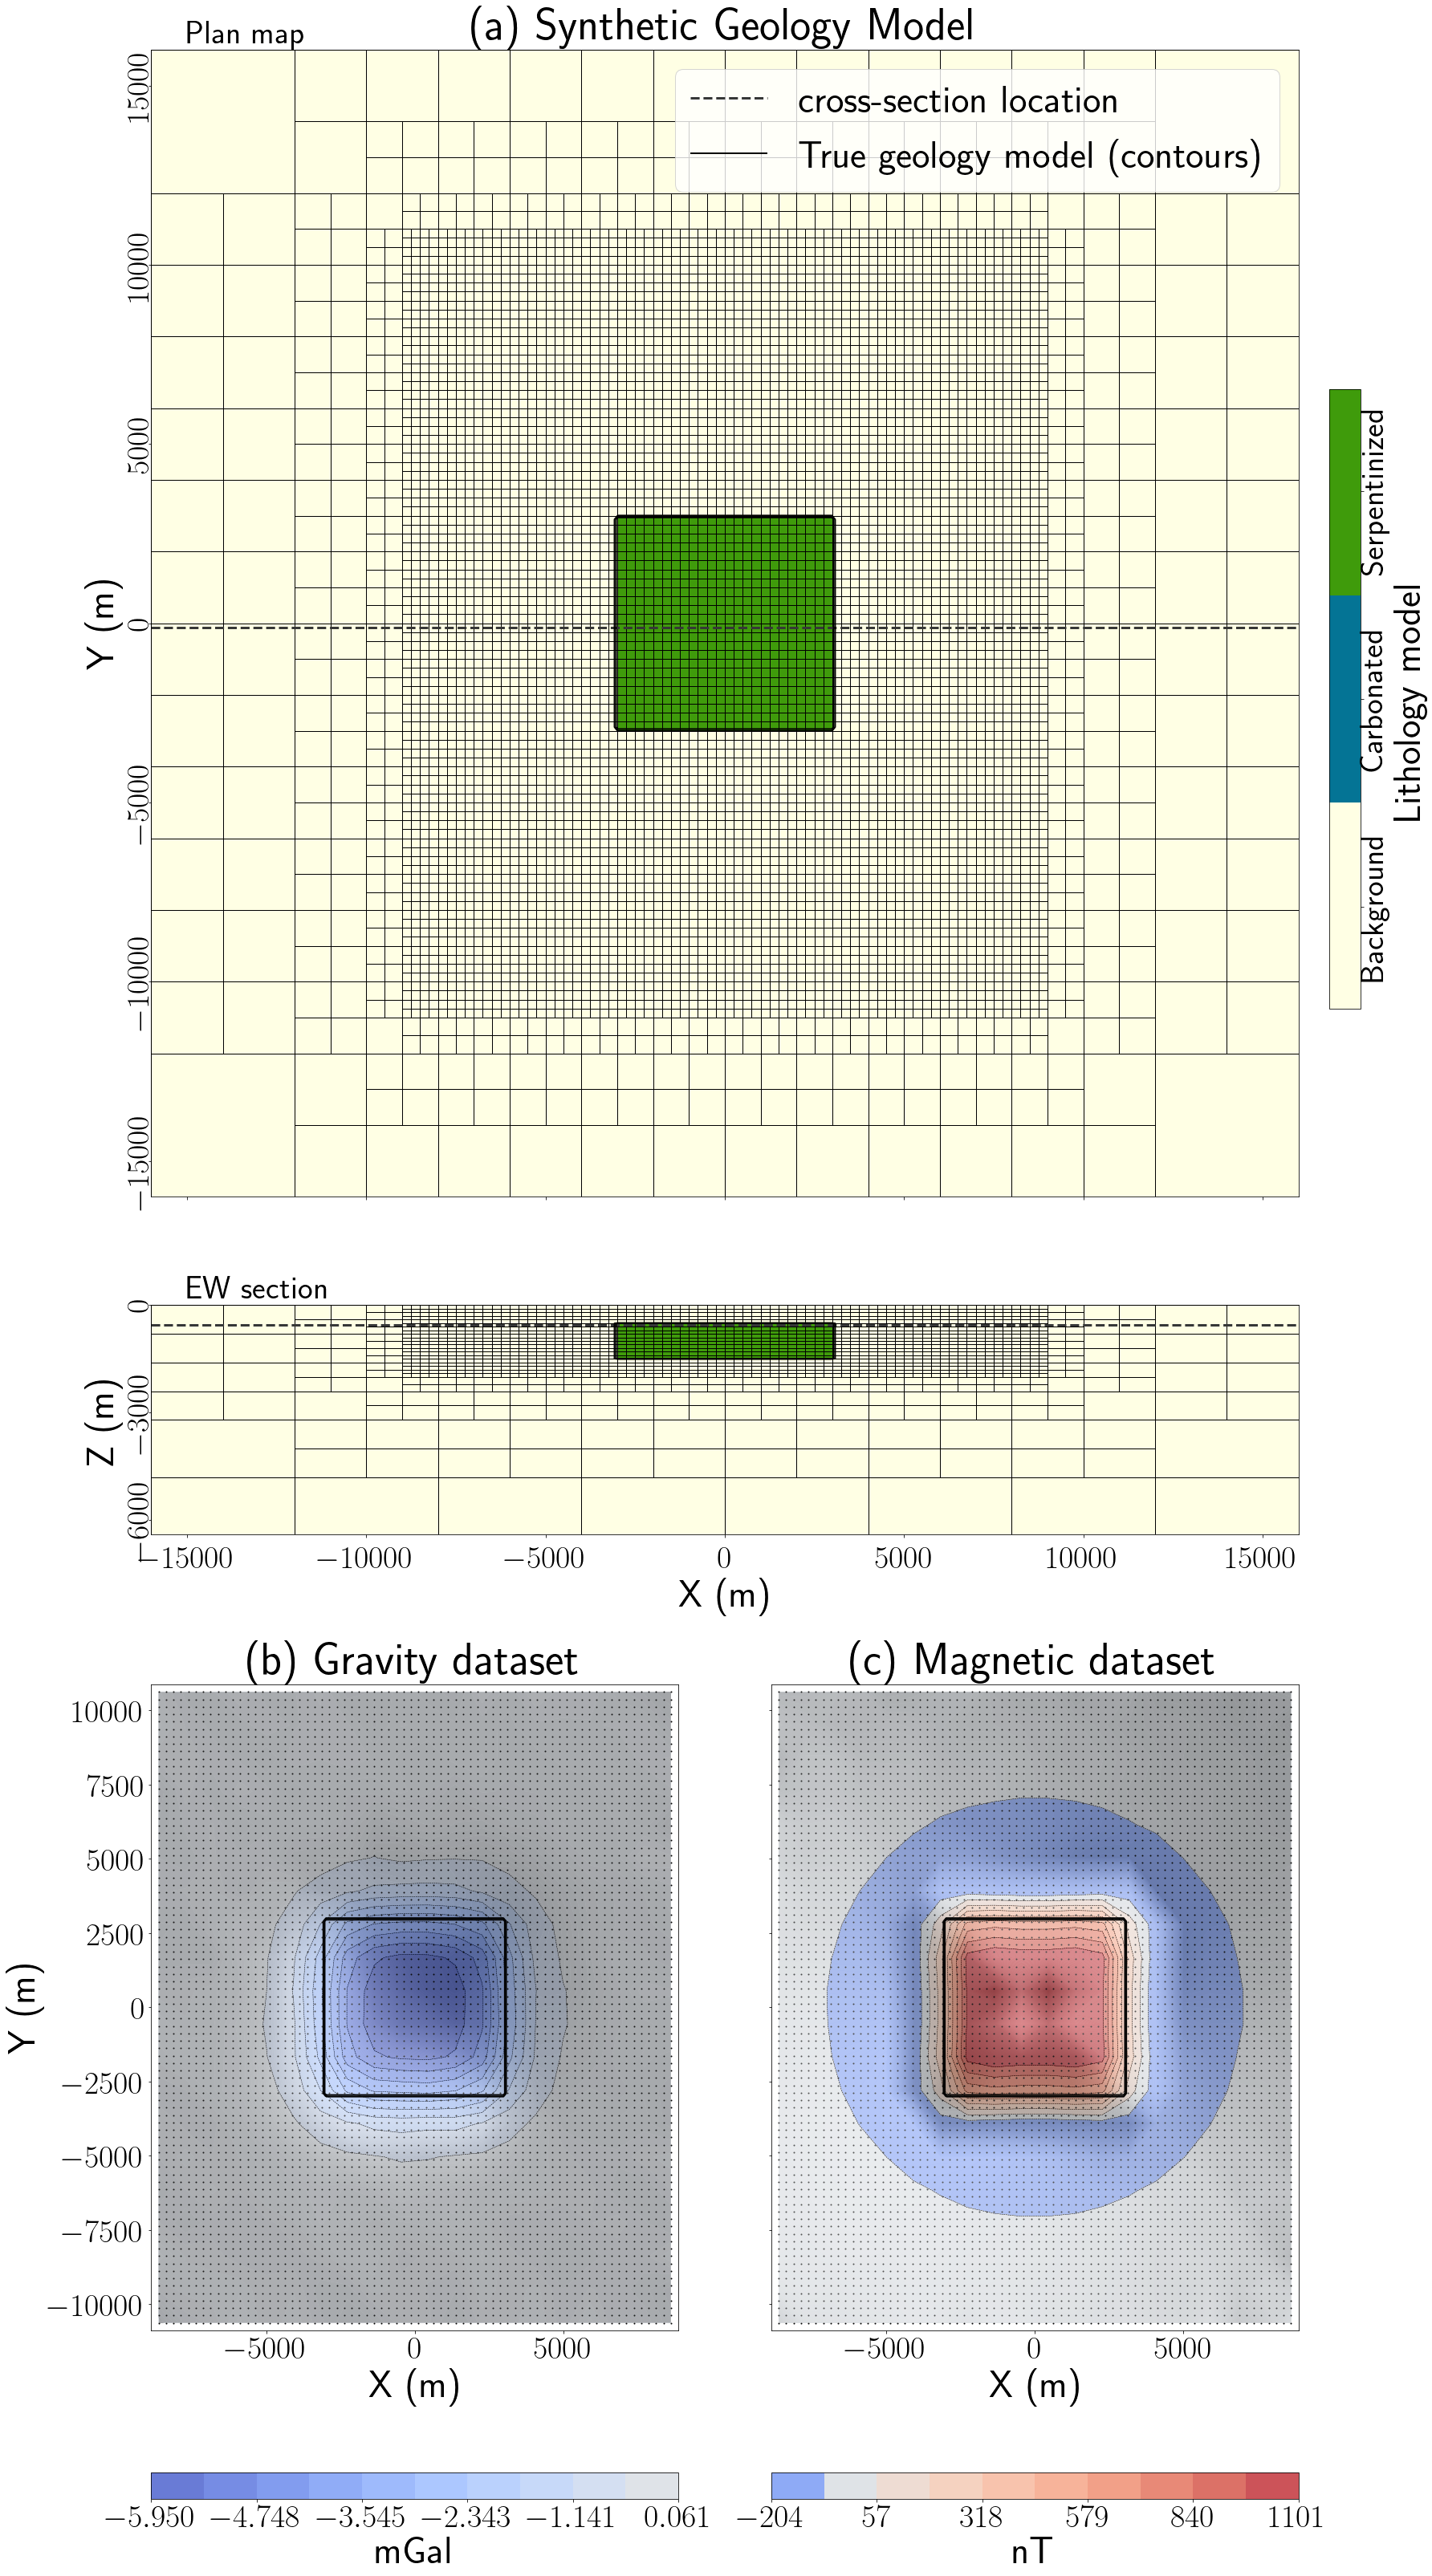

In [10]:
titlesize = 28 * 2
labelsize = 24 * 2
ticksize = 20 * 2

fig = plt.figure(figsize=(3*9,3*20))
ax0 = plt.subplot2grid((35,20,),(0, 0),colspan=19,rowspan=17)
ax1 = plt.subplot2grid((35,20,),(17, 0),colspan=19,rowspan=4)
ax2 = plt.subplot2grid((35,20,),(0, 19),colspan=1,rowspan=19)
ax3 = plt.subplot2grid((35,20,),(22, 0),colspan=9,rowspan=15)
ax4 = plt.subplot2grid((35,20,),(22, 10),colspan=9,rowspan=15)
fig.subplots_adjust(hspace=1,wspace=1)
ax = [ax0,ax1,ax2]
ax, cb = plotting_model(
    ax=ax,
    mesh=mesh,
    plot_model=geology_model,
    clim=[0,2],
    cmap=geocmap,
    legend_cb='Lithology model',
    slicex=0.,
    slicey=0.,
    slicez= -550,
    plot_grid=True,
    is_geology=True,
    titlesize = titlesize,
    labelsize = labelsize,
    ticksize = ticksize,
)
#ax[0].scatter(
#    data_grav.survey.receiver_locations[:,0],
#    data_grav.survey.receiver_locations[:,1],
#    label='Data locations',c='xkcd:dark blue',s=2)
ax[0].legend(fontsize=labelsize)
ax[0].set_title('(a) Synthetic Geology Model', fontsize=titlesize)
ax[0].text(-15000,16200,'Plan map',fontdict={'fontsize':ticksize})
ax[1].text(-15000,200,'EW section',fontdict={'fontsize':ticksize})

ax[1].tick_params(axis='both',pad=10)
ax[0].tick_params(axis='both',pad=10)
##################################
ax = [ax3,ax4]
#ax[0].set_xlim([-7500,7500])
#ax[1].set_xlim([-7500,7500])
#ax[0].set_ylim([-7500,7500])
#ax[1].set_ylim([-7500,7500])
ax[0].set_xlabel('X (m)', fontsize=labelsize)
ax[1].set_xlabel('X (m)', fontsize=labelsize)
ax[0].set_ylabel('Y (m)', fontsize=labelsize)

for axx in ax:
    axx.tick_params(labelsize=ticksize)
#mesh.plotSlice(np.ones(mesh.nC),normal='Z', ind=int(-10), grid=True,pcolorOpts={'cmap':'Greys'},ax=ax[0])
mm = utils.plot2Ddata(data_grav.survey.receiver_locations, -data_grav.dobs,
                      ax=ax[0],level=True, 
                     nx=20,ny=20, dataloc=False,ncontour=10, shade=True,
                      contourOpts={'cmap':'coolwarm', 'alpha':0.8, 'norm':norm_grav_data}, 
                      levelOpts={'colors':'k','linewidths':0.5, 'linestyles':'dashed'}
                      )
ax[0].scatter(data_grav.survey.receiver_locations[:,0],data_grav.survey.receiver_locations[:,1],label='Data locations',c='k',s=1)
#ax[0].legend(fontsize=16,loc=4)
ax[0].set_aspect(1)
ax[0].set_title('(b) Gravity dataset', fontsize=titlesize)
cb = plt.colorbar(mm[0],ax=ax[0], orientation='horizontal')
cb.set_label('mGal', fontsize=labelsize)
cb.ax.tick_params(labelsize=ticksize)

#mesh.plotSlice(np.ones(mesh.nC),normal='Z', ind=int(-10), grid=True,pcolorOpts={'cmap':'Greys'},ax=ax[1])
mm = utils.plot2Ddata(data_mag.survey.receiver_locations,data_mag.dobs,
                      ax=ax[1],level=True, 
                     nx=20,ny=20, dataloc=False,ncontour=10, shade=True,
                      contourOpts={'cmap':'coolwarm', 'alpha':0.8, 'norm':norm_mag_data},
                     levelOpts={'colors':'k','linewidths':0.5, 'linestyles':'dashed'}
)
ax[1].scatter(data_mag.survey.receiver_locations[:,0],data_mag.survey.receiver_locations[:,1],label='Data locations',c='k',s=1)

ax[1].set_title('(c) Magnetic dataset', fontsize=titlesize)
cb = plt.colorbar(mm[0],ax=ax[1], orientation='horizontal')
cb.set_label('nT', fontsize=labelsize)
ax[1].set_yticklabels([])
cb.ax.tick_params(labelsize=ticksize)

#overlay true geology model for comparison
indz = -9
indslicezplot = mesh.gridCC[:,2] == mesh.vectorCCz[indz]
for i in range(2):
    _, _, CS = utils.plot2Ddata(
            mesh.gridCC[indslicezplot][:,[0,1]],geology_model[indslicezplot],
            nx=200,ny=200,
             contourOpts={'alpha':0},
             clim=[0,2],
             ax=ax[i],
             level=True,
             ncontour=2,
             levelOpts={'colors':'k','linewidths':2,#'linestyles':'dotted',
            },
            method='nearest'
    )
    CS.collections[0].set_label('True geology outline')
    #ax[i].legend(fontsize=16,loc=4)
    ax[i].set_aspect(1)
plt.show()



In [11]:
fig.savefig('synthetic-one-block-model.png', dpi=100,bbox_inches='tight', pad_inches=0.1)

# L2

## Gravity

In [12]:
maxden = np.r_[gravity_l22+2.9,gravity_lpq+2.9].max()
minden = np.r_[gravity_l22+2.9,gravity_lpq+2.9].min()
norm_grav_model = cm.TwoSlopeNorm(vmax=maxden, vcenter=2.9, vmin=minden)


In [13]:
titlesize = 26
labelsize = 24
ticksize = 22

plotting_dict_gravity_l2 = {
    'mesh':mesh,
    'plot_model':gravity_l22+2.9,
    'clim':None,
    'cmap':'seismic',
    'legend_cb':'Density (g/cc)',
    'slicex':0.,
    'slicey':0.,
    'slicez': -550,
    'plot_grid':False,
    'plot_cb':True,
    'title':'(a) gravity inversion $\ell_2$',
    'meshplotOpts':{'norm':norm_grav_model},
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
}

plotting_dict_gravity_lpq = {
    "mesh":mesh,
    "plot_model":gravity_lpq+2.9,
    "clim":None,
    "cmap":'seismic',
    "legend_cb":'Density (g/cc)',
    "slicex":0.,
    "slicey":0.,
    "slicez": -550,
    "plot_grid":False,
    'plot_cb':False,
    'title':'(c) gravity inversion $\ell_{01}$',
    'meshplotOpts':{'norm':norm_grav_model},
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
}

In [14]:
def plot_histogram(ax,model,title,xlabel, ylim, xlim, labelsize, ticksize, titlesize, **kwargs):

    ax.hist(model, edgecolor='k',bins=100,density=True, **kwargs);
    ax.set_xlabel(xlabel, fontsize=labelsize)

    ax.set_ylabel('Normalized count', fontsize=labelsize)

    ax.set_xlim(xlim)

    ax.set_ylim(ylim)

    ax.tick_params(labelsize=ticksize)

    ax.set_title(title, fontsize=titlesize)

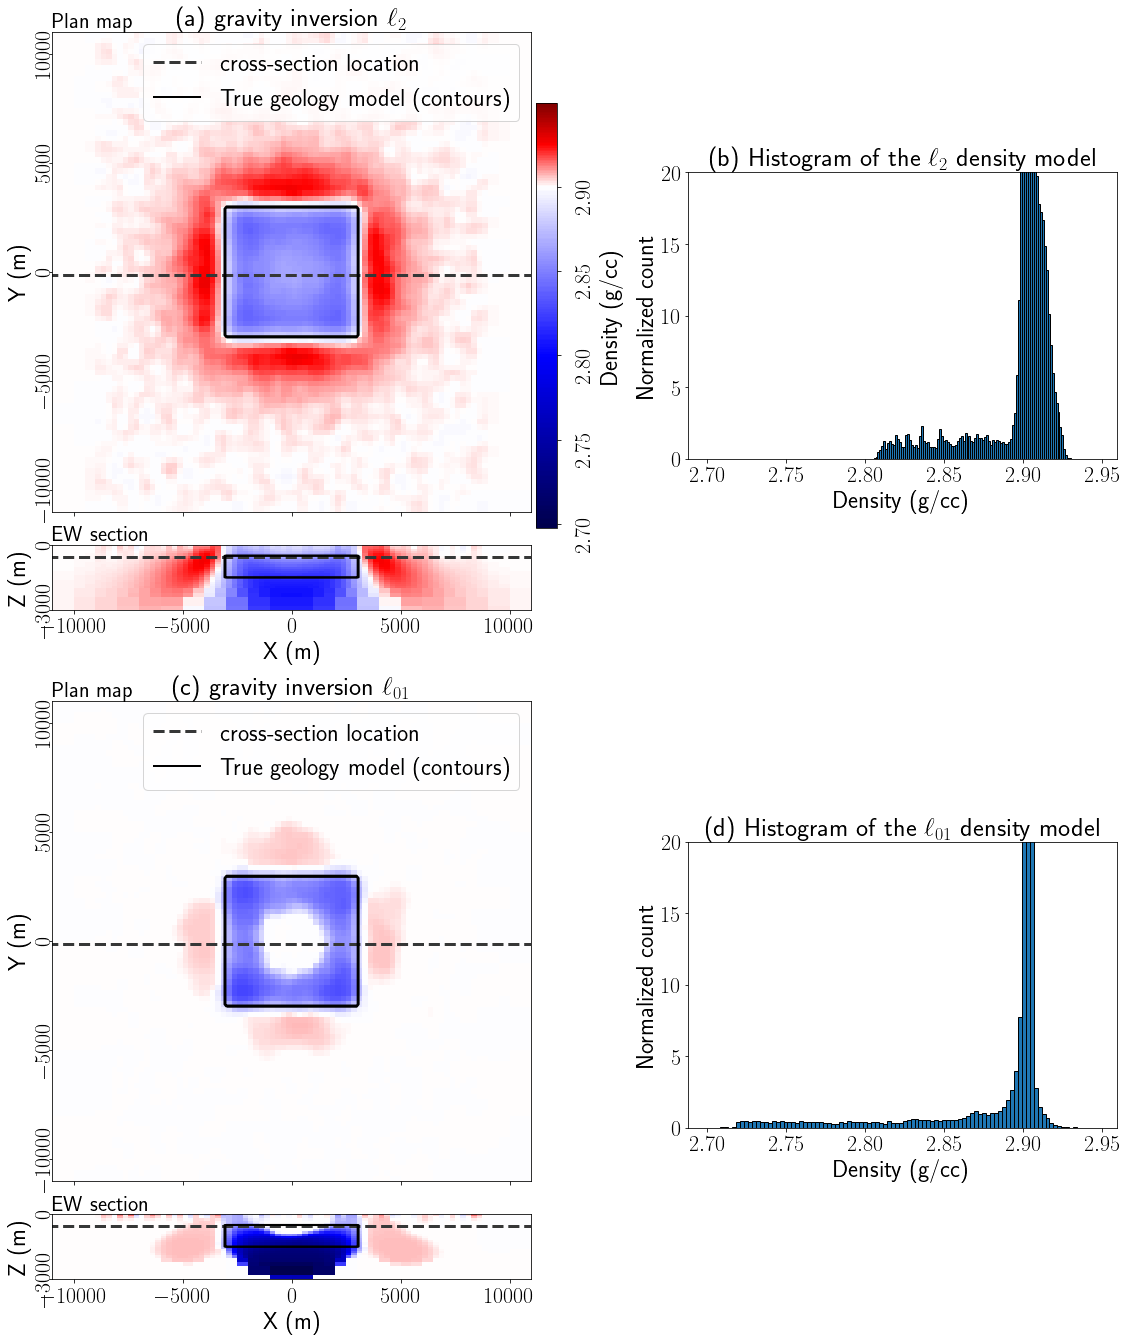

In [15]:
fig = plt.figure(figsize=(20,24))
ax_l22_0 = plt.subplot2grid((45,44,),(0, 0),colspan=19,rowspan=17)
ax_l22_1 = plt.subplot2grid((45,44,),(17, 0),colspan=19,rowspan=4)
ax_l22_2 = plt.subplot2grid((45,44,),(0, 19),colspan=1,rowspan=20)
ax_l22 = [ax_l22_0,ax_l22_1,ax_l22_2]

ax_lpq_0 = plt.subplot2grid((45,44,),(23, 0),colspan=19,rowspan=17)
ax_lpq_1 = plt.subplot2grid((45,44,),(40, 0),colspan=19,rowspan=4)
ax_lpq_2 = plt.subplot2grid((45,44,),(23, 19),colspan=1,rowspan=20)
ax_lpq = [ax_lpq_0,ax_lpq_1,ax_lpq_2]

ax_hist_l22 = plt.subplot2grid((45,44,),(5, 25),colspan=17,rowspan=10)

ax_hist_lpq = plt.subplot2grid((45,44,),(28, 25),colspan=17,rowspan=10)


for i, (dct,axx) in enumerate(zip(
    [
        plotting_dict_gravity_l2, plotting_dict_gravity_lpq, 
    ],
    [ax_l22,ax_lpq]
)):
    plotting_model(
        ax=axx,
        **dct
    )
    
ax_l22_0.set_xlim([-11000,11000])
ax_l22_0.set_ylim([-11000,11000])

ax_l22_1.set_xlim([-11000,11000])
ax_l22_1.set_ylim([-3000,0])

ax_lpq_0.set_xlim([-11000,11000])
ax_lpq_0.set_ylim([-11000,11000])

ax_lpq_1.set_xlim([-11000,11000])
ax_lpq_1.set_ylim([-3000,0])

ax_l22_0.text(-11000,11200,'Plan map',fontdict={'fontsize':ticksize})
ax_l22_1.text(-11000,200,'EW section',fontdict={'fontsize':ticksize})

ax_lpq_0.text(-11000,11200,'Plan map',fontdict={'fontsize':ticksize})
ax_lpq_1.text(-11000,200,'EW section',fontdict={'fontsize':ticksize})

plot_histogram(
    ax=ax_hist_l22,
    model=gravity_l22+2.9,
    title='(b) Histogram of the $\ell_2$ density model',
    xlabel='Density (g/cc)',
    ylim=[0,20],
    xlim=[minden-0.01,maxden+0.01],
    labelsize=labelsize,
    ticksize=ticksize,
    titlesize=titlesize
)

plot_histogram(
    ax=ax_hist_lpq,
    model=gravity_lpq+2.9,
    title='(d) Histogram of the $\ell_{01}$ density model',
    xlabel='Density (g/cc)',
    ylim=[0,20],
    xlim=[minden-0.01,maxden+0.01],
    labelsize=labelsize,
    ticksize=ticksize,
    titlesize=titlesize
)

In [16]:
fig.savefig('gravity_l22_lpq_1block.png', dpi=200,bbox_inches='tight', pad_inches=0.1)

## Magnetic

In [17]:
titlesize = 26
labelsize = 24
ticksize = 22

maxsus = 0.2
minsus = 0.

plotting_dict_magnetic_l2 = {
    'mesh':mesh,
    'plot_model':magnetic_l22,
    'clim':np.r_[minsus,maxsus],
    'cmap':'Reds',
    'legend_cb':'Magnetic susceptibility (SI)',
    'slicex':0.,
    'slicey':0.,
    'slicez': -950,
    'plot_grid':False,
    'plot_cb':True,
    'title':'(a) Magnetic inversion $\ell_{2}$',
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
}

plotting_dict_magnetic_lpq = {
    'mesh':mesh,
    'plot_model':magnetic_lpq,
    'clim':np.r_[minsus,maxsus],
    'cmap':'Reds',
    'legend_cb':'Magnetic susceptibility (SI)',
    'slicex':0.,
    'slicey':0.,
    'slicez': -950,
    'plot_grid':False,
    'plot_cb':False,
    'title':'(c) Magnetic inversion $\ell_{01}$',
    'titlesize':titlesize,
    'labelsize':labelsize,
    'ticksize':ticksize,
}

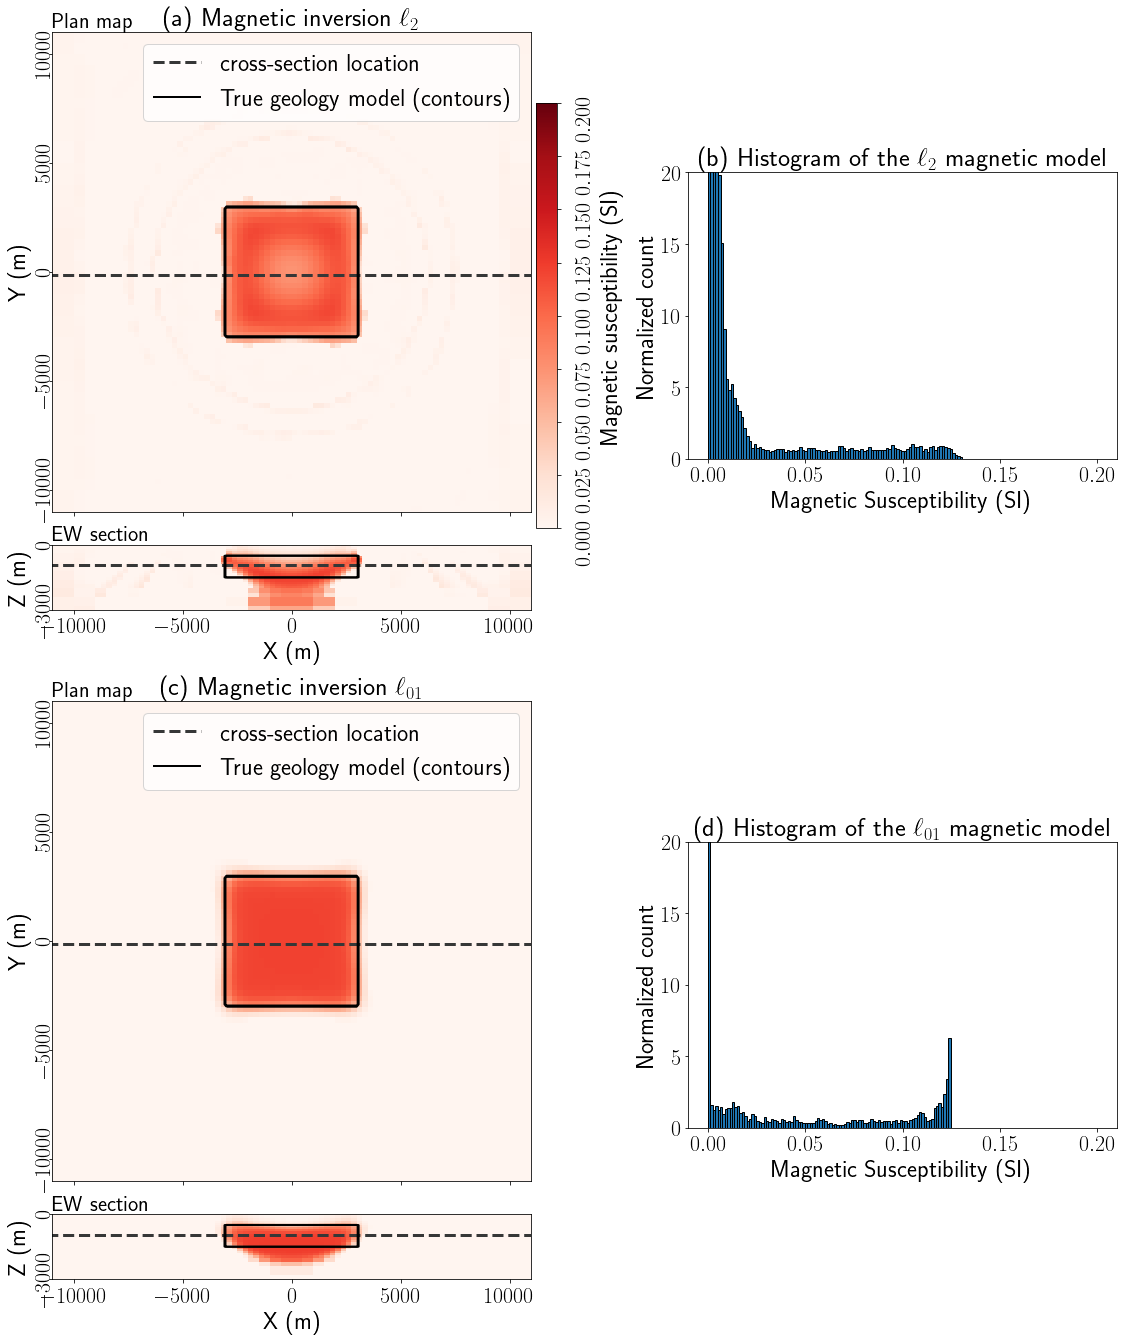

In [18]:
fig = plt.figure(figsize=(20,24))
ax_l22_0 = plt.subplot2grid((45,44,),(0, 0),colspan=19,rowspan=17)
ax_l22_1 = plt.subplot2grid((45,44,),(17, 0),colspan=19,rowspan=4)
ax_l22_2 = plt.subplot2grid((45,44,),(0, 19),colspan=1,rowspan=20)
ax_l22 = [ax_l22_0,ax_l22_1,ax_l22_2]

ax_lpq_0 = plt.subplot2grid((45,44,),(23, 0),colspan=19,rowspan=17)
ax_lpq_1 = plt.subplot2grid((45,44,),(40, 0),colspan=19,rowspan=4)
ax_lpq_2 = plt.subplot2grid((45,44,),(23, 19),colspan=1,rowspan=20)
ax_lpq = [ax_lpq_0,ax_lpq_1,ax_lpq_2]

ax_hist_l22 = plt.subplot2grid((45,44,),(5, 25),colspan=17,rowspan=10)

ax_hist_lpq = plt.subplot2grid((45,44,),(28, 25),colspan=17,rowspan=10)


for i, (dct,axx) in enumerate(zip(
    [
        plotting_dict_magnetic_l2, plotting_dict_magnetic_lpq, 
    ],
    [ax_l22,ax_lpq]
)):
    plotting_model(
        ax=axx,
        **dct
    )
    
ax_l22_0.set_xlim([-11000,11000])
ax_l22_0.set_ylim([-11000,11000])

ax_l22_1.set_xlim([-11000,11000])
ax_l22_1.set_ylim([-3000,0])

ax_lpq_0.set_xlim([-11000,11000])
ax_lpq_0.set_ylim([-11000,11000])

ax_lpq_1.set_xlim([-11000,11000])
ax_lpq_1.set_ylim([-3000,0])

ax_l22_0.text(-11000,11200,'Plan map',fontdict={'fontsize':ticksize})
ax_l22_1.text(-11000,200,'EW section',fontdict={'fontsize':ticksize})

ax_lpq_0.text(-11000,11200,'Plan map',fontdict={'fontsize':ticksize})
ax_lpq_1.text(-11000,200,'EW section',fontdict={'fontsize':ticksize})

plot_histogram(
    ax=ax_hist_l22,
    model=magnetic_l22,
    title='(b) Histogram of the $\ell_{2}$ magnetic model',
    xlabel='Magnetic Susceptibility (SI)',
    ylim=[0,20],
    xlim=np.r_[minsus-0.01,maxsus+0.01],
    labelsize=labelsize,
    ticksize=ticksize,
    titlesize=titlesize
)

plot_histogram(
    ax=ax_hist_lpq,
    model=magnetic_lpq,
    title='(d) Histogram of the $\ell_{01}$ magnetic model',
    xlabel='Magnetic Susceptibility (SI)',
    ylim=[0,20],
    xlim=np.r_[minsus-0.01,maxsus+0.01],
    labelsize=labelsize,
    ticksize=ticksize,
    titlesize=titlesize
)

In [19]:
fig.savefig('magnetic_l22_lpq_1block.png', dpi=200,bbox_inches='tight', pad_inches=0.1)